# 3. Napovedovanje aktivnosti struktur na naboru naključnih molekul

In [1]:
%run __A_knjiznice.py

# Import specific elements from the script
from __A_knjiznice import *
from __B_funkcije import *

In [2]:
directory = '/Users/samonose/PycharmProjects/IDO_inhibitors_ML_predictions/dir1/podatki_napoved'
filepath_train_data = '/Users/samonose/PycharmProjects/IDO_inhibitors_ML_predictions/dir1/molekulski_prstni_odtisi/df_circular.csv'

# Pridobitev naključnih struktur

In [3]:
import modin.pandas as pdm
df = pdm.read_csv('/Users/samonose/PycharmProjects/IDO_inhibitors_ML_predictions/dir1/podatki_napoved/df_with_fingerprints.csv')

# Read the training dataset
df_train = pdm.read_csv(filepath_train_data)

# Extract SMILES strings from the training dataset
trained_smiles = set(df_train['Smiles'])


# Filter out rows that are in the training dataset
df_filtered = df[~df['Smiles'].isin(trained_smiles)]


# Calculate the count of matches excluded
matches_count = len(df) - len(df_filtered)
print(f'Number of matches excluded: {matches_count}')

# Optionally, display the first few rows of the filtered DataFrame
df_filtered

2024-12-23 12:13:43,207	INFO worker.py:1819 -- Started a local Ray instance.
(raylet) Spilled 4256 MiB, 15 objects, write throughput 2063 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(raylet) Spilled 7840 MiB, 27 objects, write throughput 2497 MiB/s.
(raylet) Spilled 33995 MiB, 117 objects, write throughput 2783 MiB/s. [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(raylet) Spilled 66287 MiB, 406 objects, write throughput 879 MiB/s.


Number of matches excluded: 101


,Smiles,MOLPORTID,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
0,O=C1N(Cc2ccc(s2)S(=O)(=O)N2CCCc3ccccc23)C(=O)c...,Molport-007-763-075,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Cc1ccccc1NS(=O)(=O)c1ccc(CN2C(=O)c3cccnc3C2=O)s1,Molport-007-763-076,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,COc1cc(NS(=O)(=O)c2ccc(CN3C(=O)c4cccnc4C3=O)s2...,Molport-007-763-077,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Cc1c(Cl)cccc1NS(=O)(=O)c1ccc(CN2C(=O)c3cccnc3C...,Molport-007-763-078,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Cc1ccc(NS(=O)(=O)c2ccc(CN3C(=O)c4cccnc4C3=O)s2...,Molport-007-763-079,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5318939,Clc1ccc(cc1)-n1c(nc2n(ncc2c1=O)-c1ccccc1)-c1cccs1,Molport-002-191-019,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5318940,Cc1cc(Cl)cc(Cl)c1OCC(=O)Nc1ccc(O)c(c1)-c1nc2cc...,Molport-002-191-020,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5318941,CCOC(=O)C1=C(Nc2ccc(cc2)[N+]([O-])=O)S\C(=C/c2...,Molport-002-191-021,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5318942,COc1ccc(cc1)-n1nc2ccc(NC(=O)Cc3ccc(Cl)cc3)cc2n1,Molport-002-191-022,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(raylet) Spilled 131160 MiB, 632 objects, write throughput 624 MiB/s.


In [4]:
import __C_konstante as kon
import pandas as pd
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold

# Prepare the target variable (y) and features (X)
y = df_train['Activity'].values.ravel()  # Assuming 'Activity' is the target
X = df_train.iloc[:, 3:]  # Assuming features start from the 4th column

# Step 1: Remove features with no variance
var_threshold = VarianceThreshold(threshold=0)  # Remove features with variance = 0
X = var_threshold.fit_transform(X)

# Define Random Forest parameters based on your best params
rf_params = {
    'n_estimators': 110,        # Number of trees in the forest
    'max_depth': 16,            # Maximum depth of the tree
    'min_samples_split': 9,     # Minimum number of samples required to split an internal node
    'min_samples_leaf': 2,      # Minimum number of samples required to be at a leaf node
    'n_jobs': -1,               # Use all available cores
    'random_state': kon.random_seed  # Use the same random seed for reproducibility
}

# Define the pipeline steps
steps = [
    ('feature_selection', SelectKBest(score_func=chi2, k=268)),  # Using k=268 as specified
    ('classifier', RandomForestClassifier(**rf_params))  # Apply the Random Forest parameters
]

# Initialize the pipeline
pipeline = ImbPipeline(steps)

# Step 2: Train the model on the entire training dataset
pipeline.fit(X, y)

# Step 3: Load the new dataset (e.g., test dataset)
df_molport = df_filtered  # Assuming df_filtered is your new dataset

# Prepare the features from the new dataset
X_molport = df_molport.iloc[:, 2:]  # Assuming the same feature structure as the training dataset

# Step 4: Remove features with no variance from the new dataset
X_molport = var_threshold.transform(X_molport)

# Step 5: Make predictions on the new dataset directly
y_pred = pipeline.predict(X_molport)  # Directly predict using the pipeline
y_proba = pipeline.predict_proba(X_molport)  # Get probabilities

# Add the predicted activity and probability of being active (1) directly to df_molport
df_molport['Predicted_Activity'] = y_pred
df_molport['Probability_Active'] = y_proba[:, 1]  # Probability of being active (1)

# Display the relevant columns
result_df = df_molport[['Smiles', 'Predicted_Activity', 'Probability_Active']]
result_df

,Smiles,Predicted_Activity,Probability_Active
0,O=C1N(Cc2ccc(s2)S(=O)(=O)N2CCCc3ccccc23)C(=O)c...,0,0.267508
1,Cc1ccccc1NS(=O)(=O)c1ccc(CN2C(=O)c3cccnc3C2=O)s1,0,0.232777
2,COc1cc(NS(=O)(=O)c2ccc(CN3C(=O)c4cccnc4C3=O)s2...,0,0.374046
3,Cc1c(Cl)cccc1NS(=O)(=O)c1ccc(CN2C(=O)c3cccnc3C...,0,0.247475
4,Cc1ccc(NS(=O)(=O)c2ccc(CN3C(=O)c4cccnc4C3=O)s2...,0,0.485391
...,...,...,...
5318939,Clc1ccc(cc1)-n1c(nc2n(ncc2c1=O)-c1ccccc1)-c1cccs1,0,0.161349
5318940,Cc1cc(Cl)cc(Cl)c1OCC(=O)Nc1ccc(O)c(c1)-c1nc2cc...,0,0.394106
5318941,CCOC(=O)C1=C(Nc2ccc(cc2)[N+]([O-])=O)S\C(=C/c2...,0,0.295644
5318942,COc1ccc(cc1)-n1nc2ccc(NC(=O)Cc3ccc(Cl)cc3)cc2n1,0,0.207192


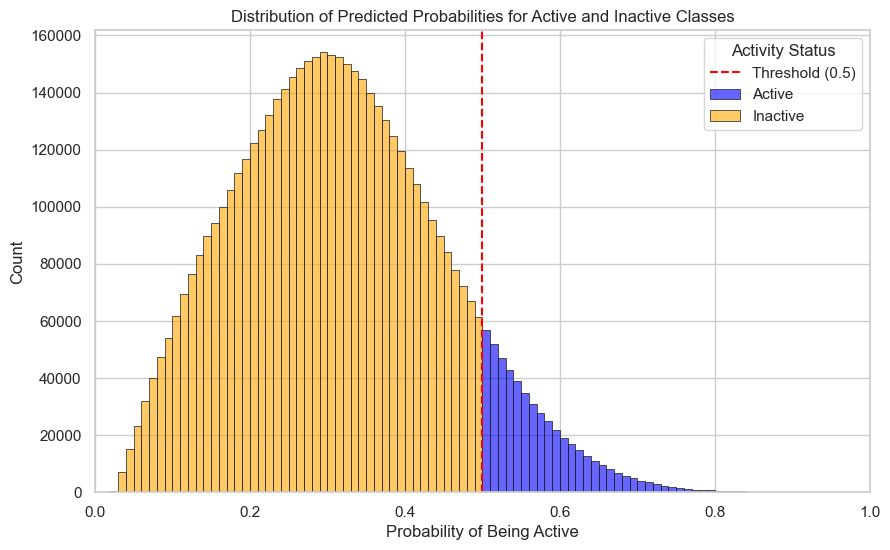

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming result_df is already defined with 'Predicted_Activity' and 'Probability_Active'

# Create a new column for the activity status based on Probability_Active
result_df['Activity_Status'] = np.where(result_df['Probability_Active'] >= 0.5, 'Active', 'Inactive')

# Set the style of seaborn
sns.set(style="whitegrid")

# Create the figure
plt.figure(figsize=(10, 6))

# Define bins for 1% increments from 0 to 1
bins = np.arange(0, 1.01, 0.01)  # 0 to 1 in steps of 0.01

# Create the histogram for Active substances
sns.histplot(data=result_df[result_df['Activity_Status'] == 'Active'], 
             x='Probability_Active', bins=bins, 
             color='blue', stat='count', edgecolor='k', label='Active', alpha=0.6)

# Create the histogram for Inactive substances
sns.histplot(data=result_df[result_df['Activity_Status'] == 'Inactive'], 
             x='Probability_Active', bins=bins, 
             color='orange', stat='count', edgecolor='k', label='Inactive', alpha=0.6)

# Add a vertical line at the 0.5 threshold for clarity
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold (0.5)')

# Add labels and title
plt.title('Distribution of Predicted Probabilities for Active and Inactive Classes')
plt.xlabel('Probability of Being Active')
plt.ylabel('Count')
plt.xlim(0, 1)  # Set x-axis limits from 0 to 1
plt.grid(True)
plt.legend(title='Activity Status')

# Show the plot
plt.show()

In [6]:
# Count the number of active predictions above specified thresholds
thresholds = [0.5, 0.75, 0.9]

# Initialize a dictionary to store counts
active_counts = {}

for threshold in thresholds:
    count_active = result_df[result_df['Probability_Active'] > threshold]['Predicted_Activity'].value_counts().get(1, 0)
    active_counts[f'Count_Active_Above_{int(threshold * 100)}%'] = count_active

# Display the counts
active_counts_df = pd.DataFrame(active_counts, index=[0])
print(active_counts_df)


the groupby keys will be sorted anyway, although the 'sort=False' was passed. See the following issue for more details: https://github.com/modin-project/modin/issues/3571.


   Count_Active_Above_50%  Count_Active_Above_75%  Count_Active_Above_90%
0                  508929                    7071                      23


In [7]:
# Filter for active predictions (Predicted_Activity == 1) and sort by Probability_Active in descending order
active_results = df_molport[df_molport['Predicted_Activity'] == 1].sort_values(by='Probability_Active', ascending=False)
active_results

,Smiles,MOLPORTID,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,...,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023,Predicted_Activity,Probability_Active
3783875,NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N/O,Molport-046-417-175,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0.965726
2007716,C[C@@H](NC(=O)c1ccc(Cl)cc1)[C@H]1CC[C@H](CC1)c...,Molport-047-919-460,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0.963312
3414216,NS(=O)(=O)NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N\O,Molport-039-137-699,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0.953737
3650738,NS(=O)(=O)NCCNc1nonc1C(Nc1ccc(F)c(Br)c1)=NO,Molport-044-723-575,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0.953737
3437988,NS(=O)(=O)NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N/O,Molport-039-330-732,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0.953737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269897,CS(=O)(=O)Nc1ccccc1C(=O)NCc1ccc(cc1)N1CCOCC1,Molport-008-386-048,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0.500001
167566,CCCOc1ccc(NC(=O)c2oc3ccc(Br)cc3c2C)c2cccnc12,Molport-008-010-981,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.500001
3728081,CS(=O)(=O)N(CCN1CCOCC1)C1CN(C1)C(=O)c1ccc(F)cc1F,Molport-046-045-947,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.500001
4858907,Cc1onc(c1C(=O)NCc1ccc2OCOc2c1)-c1ccccc1,Molport-001-489-778,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0.500001


In [8]:
active_results.head(100)

,Smiles,MOLPORTID,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,...,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023,Predicted_Activity,Probability_Active
3783875,NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N/O,Molport-046-417-175,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0.965726
2007716,C[C@@H](NC(=O)c1ccc(Cl)cc1)[C@H]1CC[C@H](CC1)c...,Molport-047-919-460,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0.963312
3414216,NS(=O)(=O)NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N\O,Molport-039-137-699,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0.953737
3650738,NS(=O)(=O)NCCNc1nonc1C(Nc1ccc(F)c(Br)c1)=NO,Molport-044-723-575,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0.953737
3437988,NS(=O)(=O)NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N/O,Molport-039-330-732,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0.953737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3355974,Fc1ccc(NC(=O)C2CCN(CC2)c2cc(ncn2)C(F)(F)F)cc1,Molport-039-025-292,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.875470
3355988,Cc1nc(cc(n1)C(F)(F)F)N1CCC(CC1)C(=O)Nc1ccc(F)cc1,Molport-039-025-306,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.875458
1517198,Cc1ccc(cc1)-c1cc(ncn1)N1CCC(CC1)C(=O)Nc1ccc(F)cc1,Molport-010-816-913,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.875404
1517009,Fc1ccc(NC(=O)C2CCN(CC2)c2cc(ncn2)-c2ccc(F)cc2)cc1,Molport-010-816-714,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.875404


In [9]:
most_active = active_results.iloc[:2000].copy()
most_active

,Smiles,MOLPORTID,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,...,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023,Predicted_Activity,Probability_Active
3783875,NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N/O,Molport-046-417-175,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0.965726
2007716,C[C@@H](NC(=O)c1ccc(Cl)cc1)[C@H]1CC[C@H](CC1)c...,Molport-047-919-460,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0.963312
3414216,NS(=O)(=O)NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N\O,Molport-039-137-699,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0.953737
3650738,NS(=O)(=O)NCCNc1nonc1C(Nc1ccc(F)c(Br)c1)=NO,Molport-044-723-575,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0.953737
3437988,NS(=O)(=O)NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N/O,Molport-039-330-732,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0.953737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791075,CC(C)CCn1c(nc2ccccc12)N1CCC(CC1)C(=O)Nc1ccc(F)cc1,Molport-006-655-614,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.799842
2643311,COC(=O)C1CCN(CC1)\C=C(/C#N)C(=O)Nc1ccc(F)cc1,Molport-002-674-710,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.799819
1052402,Fc1ccc(NC(=O)OC2CCCC(C2)NC(=O)c2ccc(Br)o2)cc1,Molport-023-209-037,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0.799786
1597736,CN(C)CCNC(=O)c1cccc2N(CCc12)C(=O)Nc1ccc(F)cc1,Molport-010-918-333,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0.799783


In [12]:
from rdkit import Chem
from rdkit.Chem import FilterCatalog

def is_pains(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 0  # Return 0 if the SMILES string is invalid
    
    # Initialize PAINS filter catalog
    params = FilterCatalogParams()
    params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS_A)
    params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS_B)
    params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS_C)
    catalog = FilterCatalog.FilterCatalog(params)  # Correct instantiation
    
    # Check for PAINS
    entry = catalog.GetFirstMatch(mol)
    return 1 if entry is not None else 0

# Apply the PAINS filter function to the 'Smiles' column
most_active['is_pains'] = most_active['Smiles'].apply(is_pains)

# Filter out PAINS molecules
df_filtered_1 = most_active[most_active['is_pains'] == 0].drop(columns=['is_pains'])

most_active_filtered = df_filtered_1[['Smiles', 'MOLPORTID', 'Predicted_Activity', 'Probability_Active']].copy()
most_active_filtered

,Smiles,MOLPORTID,Predicted_Activity,Probability_Active
3783875,NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N/O,Molport-046-417-175,1,0.965726
2007716,C[C@@H](NC(=O)c1ccc(Cl)cc1)[C@H]1CC[C@H](CC1)c...,Molport-047-919-460,1,0.963312
3414216,NS(=O)(=O)NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N\O,Molport-039-137-699,1,0.953737
3650738,NS(=O)(=O)NCCNc1nonc1C(Nc1ccc(F)c(Br)c1)=NO,Molport-044-723-575,1,0.953737
3437988,NS(=O)(=O)NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N/O,Molport-039-330-732,1,0.953737
...,...,...,...,...
791075,CC(C)CCn1c(nc2ccccc12)N1CCC(CC1)C(=O)Nc1ccc(F)cc1,Molport-006-655-614,1,0.799842
2643311,COC(=O)C1CCN(CC1)\C=C(/C#N)C(=O)Nc1ccc(F)cc1,Molport-002-674-710,1,0.799819
1052402,Fc1ccc(NC(=O)OC2CCCC(C2)NC(=O)c2ccc(Br)o2)cc1,Molport-023-209-037,1,0.799786
1597736,CN(C)CCNC(=O)c1cccc2N(CCc12)C(=O)Nc1ccc(F)cc1,Molport-010-918-333,1,0.799783


Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


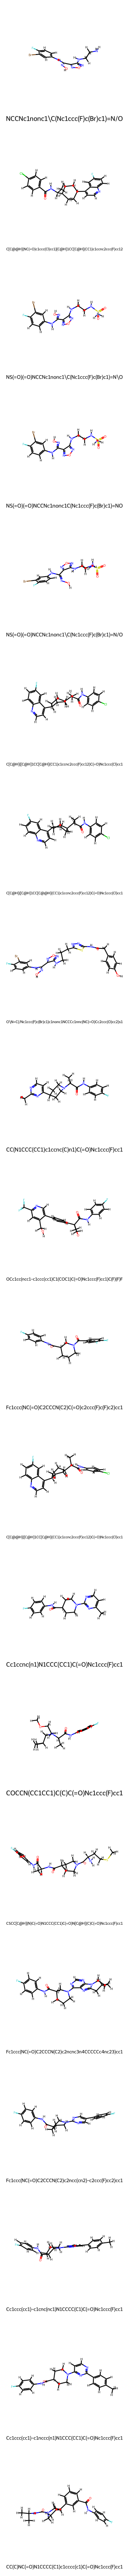

In [13]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

# Select the first five SMILES and convert to a list
smiles_list = most_active_filtered['Smiles'].head(20).tolist()

# Convert SMILES to RDKit Mol objects and generate 3D structures
molecules = []
for smiles in smiles_list:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        # Add hydrogens
        mol = Chem.AddHs(mol)
        # Generate 3D coordinates
        AllChem.EmbedMolecule(mol, randomSeed=0xf00d)
        AllChem.UFFOptimizeMolecule(mol)
        molecules.append(mol)

# Draw the molecules with SMILES as labels in separate rows
img = Draw.MolsToGridImage(molecules, molsPerRow=1, subImgSize=(300, 300), legends=smiles_list)

# Display the image
img

In [14]:
# Print out the first 20 SMILES
print("First 20 SMILES:")
for smiles in smiles_list:
    print(smiles)

First 20 SMILES:
NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N/O
C[C@@H](NC(=O)c1ccc(Cl)cc1)[C@H]1CC[C@H](CC1)c1ccnc2ccc(F)cc12
NS(=O)(=O)NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N\O
NS(=O)(=O)NCCNc1nonc1C(Nc1ccc(F)c(Br)c1)=NO
NS(=O)(=O)NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N/O
C[C@H]([C@H]1CC[C@H](CC1)c1ccnc2ccc(F)cc12)C(=O)Nc1ccc(Cl)cc1
C[C@H]([C@H]1CC[C@@H](CC1)c1ccnc2ccc(F)cc12)C(=O)Nc1ccc(Cl)cc1
O\N=C(/Nc1ccc(F)c(Br)c1)c1nonc1NCCCc1nnc(NC(=O)Cc2ccc(O)cc2)s1
CC(N1CCC(CC1)c1ccnc(C)n1)C(=O)Nc1ccc(F)cc1
OCc1cc(ncc1-c1ccc(cc1)C1(COC1)C(=O)Nc1ccc(F)cc1)C(F)(F)F
Fc1ccc(NC(=O)C2CCCN(C2)C(=O)c2ccc(F)c(F)c2)cc1
C[C@@H]([C@H]1CC[C@H](CC1)c1ccnc2ccc(F)cc12)C(=O)Nc1ccc(Cl)cc1
Cc1ccnc(n1)N1CCC(CC1)C(=O)Nc1ccc(F)cc1
COCCN(CC1CC1)C(C)C(=O)Nc1ccc(F)cc1
CSCC[C@H](N)C(=O)N1CCC(CC1)C(=O)N[C@H](C)C(=O)Nc1ccc(F)cc1
Fc1ccc(NC(=O)C2CCCN(C2)c2ncnc3n4CCCCCc4nc23)cc1
Fc1ccc(NC(=O)C2CCCN(C2)c2ncc(cn2)-c2ccc(F)cc2)cc1
Cc1ccc(cc1)-c1cnc(nc1)N1CCCC(C1)C(=O)Nc1ccc(F)cc1
Cc1ccc(cc1)-c1nccc(n1)N1CCC(CC1)C(=O)Nc1ccc(F)cc1
CC(C)NC(=O)N1CCCC(C

In [15]:
df_filtered_1.to_csv('/Users/samonose/PycharmProjects/IDO_inhibitors_ML_predictions/dir1/podatki_napoved/most_active_filtered.csv', index=False)